In [1]:
import keras as K

Using TensorFlow backend.


In [2]:
import pandas as pd
import os

In [3]:
train_dir = "../../training_images"

In [4]:
df = pd.read_csv(os.path.join(train_dir, "train_gen.csv"))

In [5]:
df.iloc[100]

patientId      03cd7a5b-d5d7-40a1-81b1-c4264920530a
x1                                              667
y1                                              125
width1                                          255
height1                                         749
confidence1                                       1
x2                                              284
y2                                              170
width2                                          215
height2                                         571
confidence2                                       1
x3                                                0
y3                                                0
width3                                            0
height3                                           0
confidence3                                       0
x4                                                0
y4                                                0
width4                                            0
height4     

In [86]:
import SimpleITK as sitk
import numpy as np
from skimage.transform import resize

class DataGenerator(K.utils.Sequence):
    """
    Generates data for Keras/TensorFlow
    Code based on https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    This uses the Keras Sequence which is better for multiprocessing.
    The main input the dataloader is a list of filenames containing
    the images to load. 
    If you have a different type of dataset, you'll just need to
    change the loading code in self.__data_generation to return
    the correct image and label.
    """
    
    def __init__(self,
                 df,     # List of file names for raw images/masks
                 path= "../../training_images", # Path for images
                 batch_size=64,  # batch size
                 dim=(128,128),  # Dimension of images
                 n_in_channels=1,  # Number of channels in image
                 shuffle=True,  # Shuffle list after each epoch
                 augment=False,   # Augment images
                 seed=816):     # Seed for random number generator
        """
        Initialization
        """
        self.dim = dim
        self.path = path
        self.batch_size = batch_size
        self.df = df
        self.n_in_channels = n_in_channels
        self.shuffle = shuffle
        self.augment = augment
        self.originalsize = self.get_size()
        self.scale = self.get_scale()
        
        np.random.seed(seed)
        self.on_epoch_end()   # Generate the sequence

    def __len__(self):
        """
        The number of batches per epoch
        """
        return len(self.df) // self.batch_size

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        # Generate indicies of the batch
        indexes = np.sort(
            self.indexes[index*self.batch_size:(index+1)*self.batch_size])

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y
    
    def normalize(self, image):
        
        """
        normalize each image by subtracting its mean and divide by the standard deviation
      
        """
        image = (image - np.mean(image))/(np.std(image))
        
        return image
    
    def resize_image(self, image):
        
        """
        resize the image into new height and new width
        
        """
        
        image = resize(image, self.dim, anti_aliasing=True, mode="constant")
        return image
    
    def get_size(self):
        """
        get the image size
        
        """
        
        info = self.df.iloc[0]
        itkimage = sitk.ReadImage(os.path.join(self.path, info["patientId"] + ".dcm"))
            
        img = np.moveaxis(sitk.GetArrayFromImage(itkimage), 0, -1)
        
        return img.shape[0], img.shape[1]
    
    def get_scale(self):
        """
        calculate the scale of the output image to the input image
        """
        info = self.df.iloc[0]
        itkimage = sitk.ReadImage(os.path.join(self.path, info["patientId"] + ".dcm"))
            
        img = np.moveaxis(sitk.GetArrayFromImage(itkimage), 0, -1)
        
        return self.dim[0]/img.shape[0], self.dim[1]/img.shape[1]

    def on_epoch_end(self):
        """
        Updates indices after each epoch
        If shuffle is true, then it will shuffle the training set
        after every epoch.
        """
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def scale_bbox(self, bbox):
        
        """
        scaling bbox
        """
        bbox = np.array(bbox)
        bbox[0::5] = bbox[0::5]/self.originalsize[0]
        bbox[1::5] = bbox[1::5]/self.originalsize[1]
        bbox[2::5] = bbox[2::5]/self.originalsize[0]
        bbox[3::5] = bbox[3::5]/self.originalsize[1]
        
        return bbox

   
    def __data_generation(self, list_IDs_temp):
        """
        Generates data containing batch_size samples
        This just reads the list of filename to load.
        Change this to suit your dataset.
        """

        # Make empty arrays for the images and bbox batches
        imgs = np.zeros((self.batch_size, *self.dim, self.n_in_channels))
        
        bboxes = np.zeros((self.batch_size, 5))  # four boxes of [X,Y,H,W,Confidence]

        for idx, file in enumerate(list_IDs_temp):
            
            info = self.df.iloc[file]
            itkimage = sitk.ReadImage(os.path.join(self.path, info["patientId"] + ".dcm"))
            
            img = np.moveaxis(sitk.GetArrayFromImage(itkimage), 0, -1)
            img = self.normalize(self.resize_image(img))
            imgs[idx,] = img
            
            # bboxes
            bboxes[idx,] = self.scale_bbox(list(info)[1:6])
            
        return imgs, bboxes

In [87]:
training_data_params = {"dim": (128,128),
                        "batch_size": 32,
                        "n_in_channels": 1,
                        "shuffle": True,
                        "seed": 810}

training_generator = DataGenerator(df=df, **training_data_params)

In [88]:
a = training_generator.__getitem__(1)

In [89]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

IndexError: index 32 is out of bounds for axis 0 with size 32

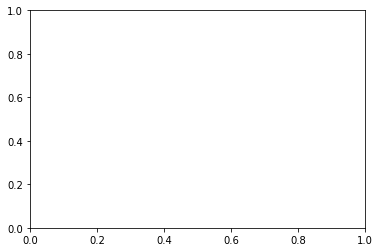

In [90]:
fig,ax = plt.subplots()

idx = 32
ax.imshow(a[0][idx,:,:,0])
x = a[1][idx,:][0] * training_data_params["dim"][0]
y = a[1][idx,:][1] * training_data_params["dim"][1]
h = a[1][idx,:][2] * training_data_params["dim"][0]
w = a[1][idx,:][3] * training_data_params["dim"][1]
rect = Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.text(x+w//2,y+h//2, str(round(a[1][idx,:][4],0)), fontsize=15)



In [91]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard

def first_model(width, height, channel):
    num_classes = 5

    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
          activation='relu',
          input_shape=(height, width, channel)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation=None))
    
    model.compile(loss="mse",
              optimizer=keras.optimizers.Adadelta(),
              metrics=['mse'])
    model.summary()
    return model
    

In [92]:
model = first_model(training_data_params['dim'][0], training_data_params['dim'][1], \
                    training_data_params['n_in_channels'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               31490176  
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

In [94]:
tensorboard = TensorBoard(log_dir="logs/singlebox", update_freq='batch')

model.fit_generator(training_generator, epochs=3, verbose=1, callbacks=[tensorboard])

Epoch 1/3
 24/802 [..............................] - ETA: 35:03 - loss: 0.0606 - mean_squared_error: 0.0606

KeyboardInterrupt: 